In [ ]:
# Uncomment when importing from GitHub
# !git clone https://www.github.com/simoneroncallo/quantum-optical-network.git
# %cd /content/quantum-optical-network
# !mkdir ./output/data

# Uncomment when importing from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'/quantum-optical-network

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/quantum-optical-network


In [ ]:
import numpy as np
import pandas as pd
import collections
from typing import Callable
from scipy.special import softmax
from keras import initializers, utils
import matplotlib.pyplot as plt
from dataprocessing import rgb2gray, dataset_preparation

# Preparation

In [ ]:
# Set the seeds
np.random.seed(2024)
utils.set_random_seed(2024)
skseed = 2024

In [ ]:
# Hyperparameters
model = 'mixture' # Choose {"mixture"}
hiddenEncoding = 'amplitude' # Choose {"phase", "amplitude"}
dataset = 'mnist' # Choose {"mnist", "fashion", "cifar"}

numTrainImgs = None # Load the full dataset with "None"
numShots = -1 # Deactivate noise with "-1" - Not implented
adam = True # Activate ADAM # Default: True

numPixels = 1024
batchSize = 1000
numEpochs = 200 # Examples {200, 150}
learningRate = 0.03
numHiddenNeurons = 2 # Examples {2,16,64,128,256}

In [ ]:
# Prepare the dataset
trainImgs, trainLabels, testImgs, testLabels = \
dataset_preparation(dataset,numTrainImgs)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set has shape (12665, 1024)
Test set has shape (2115, 1024) 



# Functions
We define all the functions to simulate and train the quantum optical network, with parameters implemented by a spatial light modulator.

In [ ]:
def layer(weights, bias, Img, model: str, num_shots):
  """ Compute the output of the quantum optical neuron, with parameters
      weights and bias, and input Img. The predicted probability is sampled
      for a given number of shots (Not yet implemented. Deactived with
      shots = -1). """
  hidden_neurons, output_weights = weights
  # normalized_prod = np.zeros(hidden_neurons.shape[0], \
  #                            dtype = np.complex64) # <I, Wi>

  if model == 'mixture':
    prod = np.einsum('i,ji->j', Img, hidden_neurons)
    hidden_norm = np.linalg.norm(hidden_neurons, axis=1)
    squareabs = np.abs(prod/hidden_norm)**2 # |<I, Wi/||W_i||>|^2

    clipped_weights = np.maximum(output_weights, 0) # Clipping (Positivity)
    rawoutput = np.dot(squareabs, clipped_weights) # / np.sum(clipped_weights)
    # sum(P(wi)|<I, Wi/||W_i||>|^2)) # Normalization removed in rawoutput

  else:
    raise ValueError('Model not available!')

  x = rawoutput + bias
  output = 1/(1 + np.exp(-x)) # Activation (Sigmoid)
  return prod, rawoutput, output

def loss(output, target):
  """ Compute the binary cross-entropy between output and target. """
  return - target*np.log(output) - (1-target)*np.log(1-output)

def accuracy(outputs, targets):
  """ Compute the total accuracy of the thresholded outputs
      against targets. """
  threshold = 0.5
  predicted = np.reshape((outputs >= threshold).astype(int),(-1))
  true_positive = np.sum(targets == predicted)
  return true_positive / len(targets)

def loss_derivative(prod, rawoutput, output, target, weights, bias,\
                    Img, model: str, encoding: str):
  """ Compute the derivative of the binary cross-entropy with respect to the
      neuron parameters, with spatial-encoded input. """
  # Check
  if output == 1:
    raise ValueError('Output is 1!')
  elif output <= 0:
    print(rawoutput,output)
    raise ValueError('Output is negative!')
  elif 1 - output <= 0:
    raise ValueError('Output is greater than 1!')

  hidden_neurons, output_weights = weights

  if encoding == 'amplitude':
    IdevsW = np.conj(Img[np.newaxis,:]) # ∂λab[prod] = <I, ∂λab[Wa]>
    # WdevsW = hidden_neurons # <W, ∂λab[Wa]> = αab
  elif encoding == 'phase':
    IdevsW = 1j*np.conj(Img[np.newaxis,:])*\
             hidden_neurons # ∂λab[prod] = <I, ∂λab[Wa]>
    # WdevsW = 1j*np.ones(hidden_neurons.shape) # <W, ∂λab[Wa]> = i
  else:
    raise ValueError('Encoding not available!')

  if model == 'mixture':
    # Compute ∂wa[f]
    fDerivativeOut = np.abs(prod)**2

    # Compute ∂λab[f]
    fDerivativeHidden = 2*(output_weights)[:,np.newaxis]*\
                        np.real(IdevsW * np.conj(prod)[:,np.newaxis])

  else:
    raise ValueError('Model not available!')

  F, f, y = output, rawoutput, target
  crossDerivative = (F - y)/(F*(1-F))

  x = f + bias
  sigmoid = 1/(1 + np.exp(-x)) # Activation function (Sigmoid)
  actdev = sigmoid*(1-sigmoid) # Activation derivative

  lossDerivativeOut = crossDerivative*actdev*fDerivativeOut
  lossDerivativeHidden = crossDerivative*actdev*fDerivativeHidden
  lossDerivativeBias = crossDerivative*actdev

  return lossDerivativeHidden, lossDerivativeOut, lossDerivativeBias

def optimization(loss_derivative: Callable, hidden_params, hidden_neurons,\
                 output_weights, bias, targets, test_targets, trainImgs,\
                 testImgs, num_epochs, lr, batch_size, model: str,\
                 encoding: str, adam: bool, num_shots = -1):
  """ Gradient descent optimization. """
  weights = (hidden_neurons, output_weights)
  num_batches = trainImgs.shape[0] // batch_size
  shuffled_idxs = np.arange(trainImgs.shape[0])

  # History initialization
  loss_history = np.zeros((num_epochs))
  accuracy_history = np.zeros((num_epochs))
  test_loss_history = np.zeros((num_epochs))
  test_accuracy_history = np.zeros((num_epochs))

  # Loss derivative initialization
  lossDerivativeHiddenDataset = np.zeros((trainImgs.shape[0],\
                              hidden_neurons.shape[0], hidden_neurons.shape[1]))
  lossDerivativeOutDataset = np.zeros((trainImgs.shape[0],\
                                       output_weights.shape[0]))
  lossDerivativeBiasDataset = np.zeros(trainImgs.shape[0])

  # Initialize ADAM
  m_hidden, v_hidden, m_output, v_output, m_bias, v_bias = None, None, None,\
   None, None, None

  for epoch in range(num_epochs):
    np.random.shuffle(shuffled_idxs)

    for batch in range(num_batches):
      batchIdx = shuffled_idxs[batch * batch_size : (batch + 1) * batch_size]

      # Get batch data
      batchImgs = trainImgs[batchIdx,:]
      batchLabels = targets[batchIdx]

      # Training set
      results = [layer(weights, bias, img, model,\
                       num_shots) for img in batchImgs]
      prods = np.array([result[0] for result in results])
      rawoutputs = np.array([result[1] for result in results])
      outputs = np.array([result[2] for result in results])

      # Initialize mean loss derivatives for the batch
      meanLossDerivativeHiddenBatch = np.zeros((hidden_neurons.shape[0],\
                                                hidden_neurons.shape[1]))
      meanlossDerivativeOutBatch = np.zeros((output_weights.shape[0]))
      meanlossDerivativeBiasBatch = 0

      # Compute the sum of the derivatives for the batch
      for idx in range(batch_size):
          devHidden, devOut, devBias =\
            loss_derivative(prods[idx],\
                  rawoutputs[idx], outputs[idx], batchLabels[idx],\
                    weights, bias, batchImgs[idx, :], model, encoding)

          meanLossDerivativeHiddenBatch += devHidden
          meanlossDerivativeOutBatch += devOut
          meanlossDerivativeBiasBatch += devBias

      # Compute mean loss derivatives for the batch
      meanLossDerivativeHiddenBatch /= batch_size
      meanlossDerivativeOutBatch /= batch_size
      meanlossDerivativeBiasBatch /= batch_size

      hidden_params, weights, bias, m_hidden, v_hidden, m_output, v_output,\
      m_bias, v_bias =\
        update_rule(hidden_params, weights, bias, meanLossDerivativeHiddenBatch,\
          meanlossDerivativeOutBatch, meanlossDerivativeBiasBatch,\
            lr, model, encoding, adam, m_hidden=m_hidden,\
            v_hidden = v_hidden, m_output = m_output, v_output = v_output,\
              m_bias = m_bias, v_bias = v_bias,\
                t = epoch * num_batches + batch + 1)

    ## Training set
    # Update outputs
    results = [layer(weights, bias, trainImgs[idx,:],\
                    model, num_shots) for idx in range(trainImgs.shape[0])]
    prods = np.array([result[0] for result in results])
    rawoutputs = np.array([result[1] for result in results])
    outputs = np.array([result[2] for result in results])

    losses = loss(outputs, targets)
    loss_history[epoch] = np.mean(losses)

    # Update accuracy
    accuracy_history[epoch] = accuracy(outputs, targets)

    ## Validation set
    # Update outputs
    results = [layer(weights, bias, testImgs[idx,:], model,\
                              num_shots) for idx in range(testImgs.shape[0])]
    test_prods = np.array([result[0] for result in results])
    test_rawoutputs = np.array([result[1] for result in results])
    test_outputs = np.array([result[2] for result in results])

    # Update loss
    test_losses = loss(test_outputs, test_targets)
    test_loss_history[epoch] = np.mean(test_losses)

    # Update accuracy
    test_accuracy_history[epoch] = accuracy(test_outputs, test_targets)

    # Verbose
    print('EPOCH', epoch)

    print('Loss', loss_history[epoch], \
          'Val_Loss', test_loss_history[epoch] )

    print('Accuracy', accuracy_history[epoch], \
          'Val_Acc', test_accuracy_history[epoch])

    print('---')

  return weights, bias, loss_history, test_loss_history, accuracy_history, \
          test_accuracy_history

def update_rule(hidden_params, weights, bias, grad_hidden, grad_output,\
                grad_bias, lr, model: str, encoding: str, adam: bool,\
                beta1=0.9, beta2=0.999, epsilon=1e-8,
                m_hidden=None, v_hidden=None, m_output=None, v_output=None,
                m_bias=None, v_bias=None,
                t=1):
  """ Parameters update rule of the gradient descent algorithm. """
  hidden_neurons, output_weights = weights

  # Initialize moments if they are None
  if m_hidden is None:
    m_hidden = np.zeros_like(hidden_params)
    v_hidden = np.zeros_like(hidden_params)
  if m_output is None:
    m_output = np.zeros_like(output_weights)
    v_output = np.zeros_like(output_weights)
  if m_bias is None:
    m_bias = np.zeros_like(bias)
    v_bias = np.zeros_like(bias)

  # Update biased first moment estimate
  m_hidden = beta1 * m_hidden + (1 - beta1) * grad_hidden
  m_output = beta1 * m_output + (1 - beta1) * grad_output
  m_bias = beta1 * m_bias + (1 - beta1) * grad_bias

  # Update biased second raw moment estimate
  v_hidden = beta2 * v_hidden + (1 - beta2) * (grad_hidden ** 2)
  v_output = beta2 * v_output + (1 - beta2) * (grad_output ** 2)
  v_bias = beta2 * v_bias + (1 - beta2) * (grad_bias ** 2)

  # Compute bias-corrected first moment estimate
  m_hat_hidden = m_hidden / (1 - beta1**t)
  m_hat_output = m_output / (1 - beta1**t)
  m_hat_bias = m_bias / (1 - beta1**t)

  #  Compute bias-corrected second raw moment estimate
  v_hat_hidden = v_hidden / (1 - beta2**t)
  v_hat_output = v_output / (1 - beta2**t)
  v_hat_bias = v_bias / (1 - beta2**t)

  # Update parameters
  if adam == True:
    new_hidden_params = hidden_params - lr*m_hat_hidden/\
                        (np.sqrt(v_hat_hidden) + epsilon)
    new_output_weights = output_weights - lr*m_hat_output/\
                        (np.sqrt(v_hat_output) + epsilon)
    new_bias = bias - lr*m_hat_bias/(np.sqrt(v_hat_bias) + epsilon)

  else:
    new_hidden_params = hidden_params - lr*grad_hidden
    new_output_weights = output_weights - lr*grad_output
    new_bias = bias - lr*grad_bias

  if encoding == 'amplitude':
    new_hidden_neurons = new_hidden_params

  elif encoding == 'phase':
    new_hidden_neurons = np.exp(1j*new_hidden_params)

  else:
    raise ValueError('Encoding not available!')

  new_weights = (new_hidden_neurons, new_output_weights)
  return new_hidden_params, new_weights, new_bias, m_hidden, v_hidden,\
   m_output, v_output, m_bias, v_bias

# <font color='ORANGE'>Training</font>

In [ ]:
# Hidden layer
initial_hidden_params = initializers.GlorotUniform()(\
                        shape=(numHiddenNeurons, numPixels)).numpy()

if hiddenEncoding == 'amplitude':
  initial_hidden_neurons = initial_hidden_params
elif hiddenEncoding == 'phase':
  initial_hidden_neurons = np.exp(1j*initial_hidden_params)
else:
    raise ValueError('Encoding not available!')

# Output layer
initial_bias = 0
if model == 'mixture':
  initial_output_weights = initializers.GlorotUniform()(\
                          shape=(numHiddenNeurons,)).numpy()

In [ ]:
# Training
weights, bias, loss_history, test_loss_history, accuracy_history,\
              test_accuracy_history =\
               optimization(loss_derivative,\
                initial_hidden_params, initial_hidden_neurons,\
                  initial_output_weights, initial_bias, trainLabels,\
                    testLabels, trainImgs, testImgs, numEpochs, learningRate,\
                      batchSize, model, hiddenEncoding, adam, numShots)

EPOCH 0
Loss 0.6514355304103687 Val_Loss 0.6497981011914883
Accuracy 0.5323332017370707 Val_Acc 0.5366430260047281
---
EPOCH 1
Loss 0.6335375268986202 Val_Loss 0.6319273616999156
Accuracy 0.9621792341097513 Val_Acc 0.9749408983451536
---
EPOCH 2
Loss 0.6145200766230169 Val_Loss 0.6124133217451014
Accuracy 0.9632056849585472 Val_Acc 0.9754137115839243
---
EPOCH 3
Loss 0.5939646371979752 Val_Loss 0.5914602293157679
Accuracy 0.9767864192656929 Val_Acc 0.9853427895981087
---
EPOCH 4
Loss 0.5720692789546432 Val_Loss 0.5690908529694555
Accuracy 0.9797868140544809 Val_Acc 0.9895981087470449
---
EPOCH 5
Loss 0.5490778602166276 Val_Loss 0.5457421237095713
Accuracy 0.9857086458744572 Val_Acc 0.9929078014184397
---
EPOCH 6
Loss 0.5262963862622984 Val_Loss 0.5224956597590691
Accuracy 0.9862613501776549 Val_Acc 0.9938534278959811
---
EPOCH 7
Loss 0.5034364637075271 Val_Loss 0.49926416925802386
Accuracy 0.9874457165416503 Val_Acc 0.9952718676122931
---
EPOCH 8
Loss 0.481345957451444 Val_Loss 0.47669

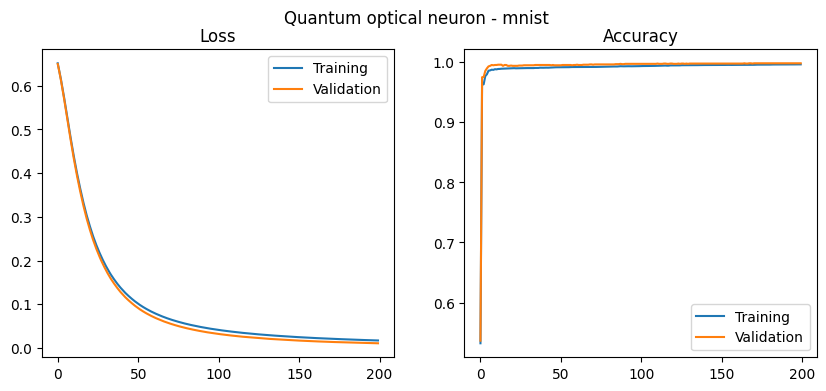

In [ ]:
# History plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(loss_history, label = 'Training')
ax1.plot(test_loss_history, label = 'Validation')

ax1.set_title('Loss')
ax1.legend()

ax2.plot(accuracy_history, label = 'Training')
ax2.plot(test_accuracy_history, label = 'Validation')

ax2.set_title('Accuracy')
ax2.legend()

fig.suptitle(f'Quantum optical neuron - {dataset}')
plt.show()

# Save

In [ ]:
# Save
# np.save(f'output/data/{dataset}/Loss{numHiddenNeurons}Hidden_{dataset}.npy',\
#         loss_history)
# np.save(f'output/data/{dataset}/TestLoss{numHiddenNeurons}Hidden_{dataset}.npy',\
#         test_loss_history)
# np.save(f'output/data/{dataset}/Accuracy{numHiddenNeurons}Hidden_{dataset}.npy',\
#         accuracy_history)
# np.save(f'output/data/{dataset}/TestAccuracy{numHiddenNeurons}Hidden_{dataset}.npy',\
#         test_accuracy_history)